In [116]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import wcs
import pickle

import sys
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils
from scipy.optimize import curve_fit
import scipy

In [118]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '../zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# these are in nW/m^2/sr, but I want to convert them to kJy/sr
# I have to divide by the bandwidth of 0.5um
lamda_m = 1.1e-6
freq_Hz = 3.e8/lamda_m
convert_to_kJy_per_sr = 1.e-9/freq_Hz/(1.e3*1.e-26)

ell_Cell_ciber[:,1] *= convert_to_kJy_per_sr
# ell_Cell_eormodel[:,1] *= convert_to_kJy_per_sr

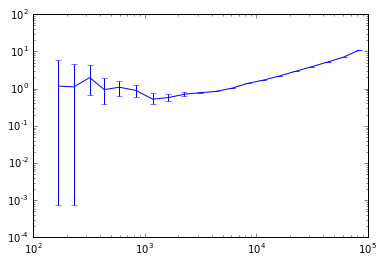

In [83]:
plt.errorbar(ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1],yerr=[ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1],\
                                                                 ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1]])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [84]:
# labels = '02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I'.split()
labels = '02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I'.split()
analysis_name = '_'.join([l.split('o')[1] for l in labels])
print(analysis_name)

run = 'ATLAS_mwa57694_rereduction'
xcor_data_dir = '/home/abrahamn/xcor_data/'
raw_frames_root = xcor_data_dir+run+'/'
analysis_root = xcor_data_dir+'analysis/'+run+'/' + analysis_name + '/'

0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I


In [85]:
# secat = pickle.load( open('/Users/abrahamn/Documents/MIT/21cm/21cmIR/ir_catalogs/whole_field_secat.p', "rb" ) )
# g = secat.jy>1.e-10
# secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

# srcdat = np.genfromtxt(raw_frames_root+labels[0]+'.dph')
# dphcat = cat_utils.Catalog(srcdat[:,0],srcdat[:,1],3631*10.**(-srcdat[:,2]/2.5))

secat = cat_utils.IRCatalog(se_path=analysis_root+analysis_name+'.sex',se_magzpt=20.46)
g = secat.jy_all>1.e-10
secat = cat_utils.Catalog(secat.ra_all[g],secat.dec_all[g],secat.jy_all[g])

loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I.sex


In [86]:
# plt.figure(figsize=(14,12))
# plt.scatter(secat.ra,secat.dec,secat.jy*5000,facecolors='red',edgecolors='none')
# plt.scatter(dphcat.ra,dphcat.dec,dphcat.jy*5000,facecolors='none')

# plt.xlim([-2,-1])
# plt.ylim([-31,-30])

In [87]:
img_fits_path = analysis_root+analysis_name+'.fits'

hdulist_img = fits.open(img_fits_path)
img = hdulist_img[0].data
h = hdulist_img[0].header
n = img.shape[0]
hdulist_img.close()

x,y = np.where(img != 0)
x_med, y_med = np.median(x),np.median(y)

In [88]:
regfiletest = open(analysis_root+'regfiletest.reg','w')

regfiletest.write('# Region file format: DS9 version 4.1\n')
regfiletest.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
regfiletest.write('icrs\n')

radmin,radmax = 7.5,60
logjymin,logjymax = -5,0
def rad_asec_for_jy(jy):
    return jy*25+(radmax-radmin)/(logjymax-logjymin)*(np.log10(jy)-logjymin)+radmin
def rad_asec_for_jy_old(jy):
    radmax=40
    return jy*15+(radmax-radmin)/(logjymax-logjymin)*(np.log10(jy)-logjymin)+radmin
secat_rad = rad_asec_for_jy(secat.jy)

for i in range(len(secat.jy)):
    regfiletest.write("circle(%f,%f,%f\")\n"%(secat.ra[i],secat.dec[i],secat_rad[i]))
                                              

regfiletest.close()

In [89]:
# #hi = plt.hist(np.log10(secat.jy),np.linspace(-5,0),histtype='step',color='blue')
# # hi = plt.hist(np.log10(srcjy),np.linspace(-5,0),histtype='step',color='red')
# hi = plt.hist(np.log10(secat.jy),np.linspace(-5,2),histtype='step',color='cyan')
# plt.gca().set_yscale('log')

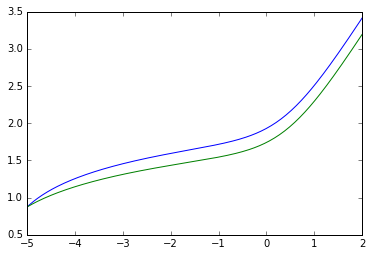

In [90]:
logjyvals = np.linspace(-5,2,200)
plt.plot(logjyvals,np.log10(rad_asec_for_jy(10.**logjyvals)))
plt.plot(logjyvals,np.log10(rad_asec_for_jy_old(10.**logjyvals)))

In [91]:
img_fits_path = analysis_root+analysis_name+'.fits'
hdulist_img = fits.open(img_fits_path)
img = hdulist_img[0].data
h = hdulist_img[0].header
n = img.shape[0]
hdulist_img.close()

w = wcs.WCS(h)
mask = np.ones(img.shape)
asec_per_pixel = np.abs(h['CD1_1'])*3600

In [92]:
def mask_circle_in_image(m,xcent,ycent,r):
    n=m.shape[0]
    if not ((0<=xcent<n) and (0<=ycent<n)): return
    for y in range(-int(r),int(r)+1): # x is the x distance from circle center
        if not (0 <= ycent+y < n): continue
        #print(n)
        #print(int(xcent-np.sqrt(r**2-y**2)),int(xcent+np.sqrt(r**2-y**2)))
        #rint(max(0,int(xcent-np.sqrt(r**2-y**2))),min(n,int(xcent+np.sqrt(r**2-y**2))),)
        m[ycent+y,max(0,int(xcent-np.sqrt(r**2-y**2))):min(n,int(xcent+np.sqrt(r**2-y**2)))] = 0


In [93]:
px,py = w.wcs_world2pix(secat.ra,secat.dec,1)

# draw a filled circle of zeros on the mask image for each source
for i in range(len(secat.ra)):
    if i % 2500 == 0: print(1.*i/len(secat.ra))
    mask_circle_in_image(mask,px[i],py[i],secat_rad[i]/asec_per_pixel)

0.0


/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.0479662317728
0.0959324635457
0.143898695318
0.191864927091
0.239831158864
0.287797390637
0.33576362241
0.383729854183
0.431696085955
0.479662317728
0.527628549501
0.575594781274
0.623561013047
0.67152724482
0.719493476592
0.767459708365
0.815425940138
0.863392171911
0.911358403684
0.959324635457


/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


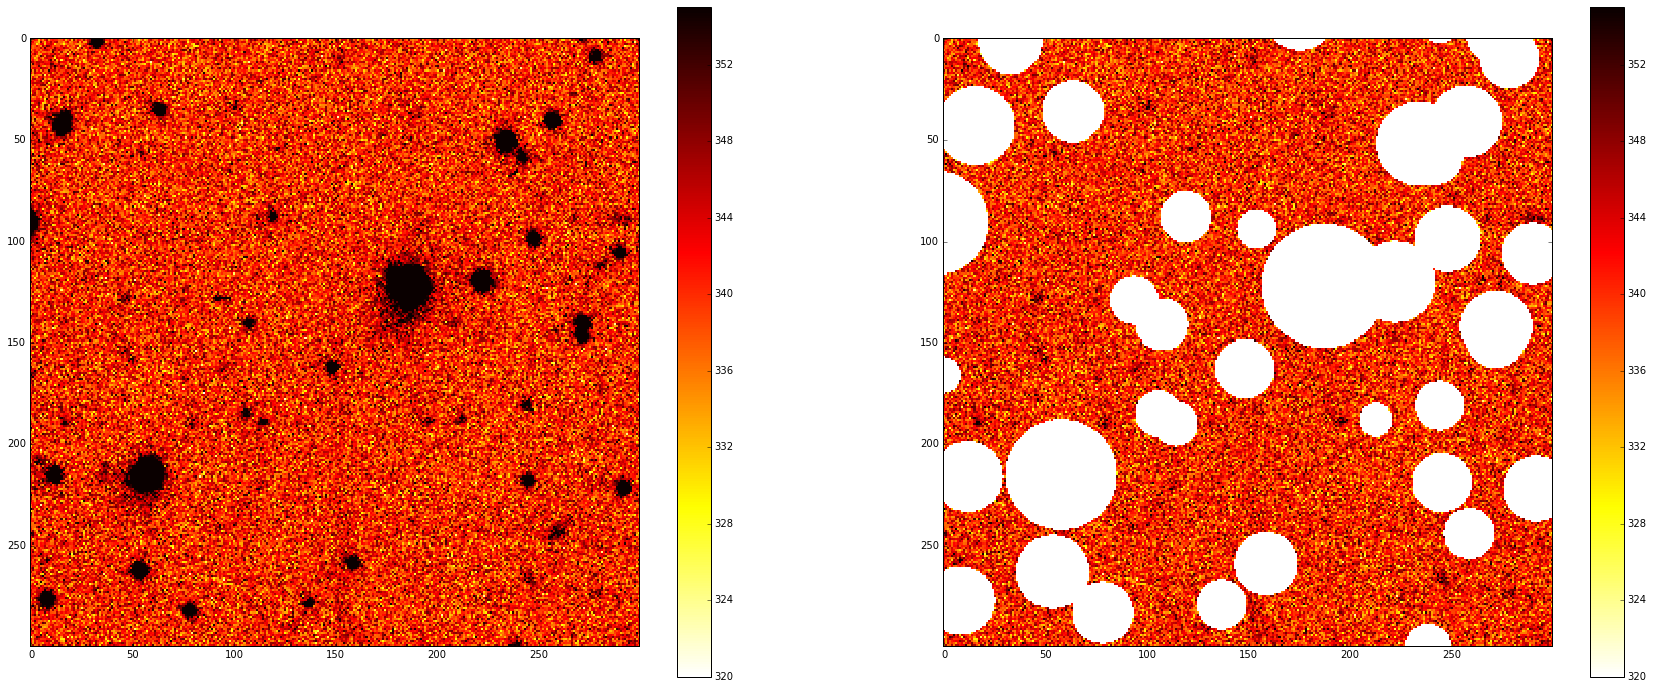

In [94]:
plt.figure(figsize=(30,12))

# x0,x1 = 6400,7000
# y0,y1 = 15200,15800
# x0,x1 = 2400,12000
# y0,y1 = 10400,22600
v0,v1 = 320,355
dd = 150
x0,x1 = x_med-dd,x_med+dd
y0,y1 = y_med-dd,y_med+dd
skip=1

plt.subplot(121)
plt.imshow(img[x0:x1:skip,y0:y1:skip],vmin=v0,vmax=v1,cmap='hot_r',interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.imshow(img[x0:x1:skip,y0:y1:skip]*mask[x0:x1:skip,y0:y1:skip],vmin=v0,vmax=v1,cmap='hot_r',interpolation='nearest')
plt.colorbar()

In [95]:
target_coarse_res_asec = 7.*60
fine_pixel_asec = 1.86
coarse_bin_factor = int(np.round(target_coarse_res_asec/fine_pixel_asec))
print(coarse_bin_factor)
dtheta_coarse_rad = fine_pixel_asec*coarse_bin_factor/3600*np.pi/180

n_coarse = int(n/coarse_bin_factor)
n_fine_max = n_coarse*coarse_bin_factor

226


In [96]:
img_binned_avgunmasked = np.zeros((n_coarse,n_coarse))
img_binned_counts = np.zeros((n_coarse,n_coarse))

binedges = np.linspace(300,500,300)
for i in range(n_coarse):
    if i % 15 == 0: print(1.*i/n_coarse)
    for j in range(n_coarse):
        img_in_this_coarse_bin = img[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
        mask_in_this_coarse_bin = mask[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
        if np.any(img_in_this_coarse_bin==0) or np.sum(mask_in_this_coarse_bin)<.4*coarse_bin_factor**2: continue
        
        img_binned_counts[i,j] = np.sum(mask_in_this_coarse_bin)
        
        unmasked_vals_in_this_coarse_bin = img_in_this_coarse_bin[1==mask_in_this_coarse_bin]
        g = unmasked_vals_in_this_coarse_bin<np.percentile(unmasked_vals_in_this_coarse_bin,99)
        img_binned_avgunmasked[i,j] = np.mean(unmasked_vals_in_this_coarse_bin[g])
                
#         counts,binedges = np.histogram(img_in_this_coarse_bin[mask_in_this_coarse_bin].flatten(),binedges)
#         bins = .5*(binedges[1:]+binedges[:-1])

#         g = counts>np.max(counts)*.05
        
#         try:
#             coeff, var_matrix = curve_fit(gauss, bins[g], counts[g],\
#                                           p0=[np.max(counts),np.median(img_in_this_coarse_bin[1==mask_in_this_coarse_bin]),10],\
#                                           sigma=np.sqrt(counts[g]))
#             img_binned_fitunmasked[i,j] = coeff[1]
#         except:
#             pass

0.0
0.147058823529
0.294117647059
0.441176470588
0.588235294118
0.735294117647
0.882352941176


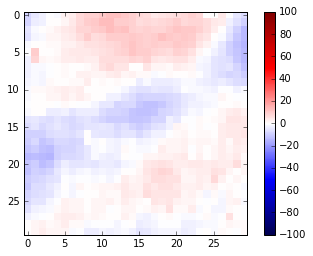

In [104]:
# so now let's use the inverse variance weighted power spectrum estimator,
# and compare it to the FFT power spectrum

fov_deg = 3.6
d = int(fov_deg*np.pi/180/dtheta_coarse_rad)

dtheta_rad = 1.86/3600*np.pi/180
x0 = int(x_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
x1 = x0+d
y0 = int(y_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
y1 = y0+d

magzpt = 20.56
exp_time_sec = 30

conv = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_coarse_rad**2*coarse_bin_factor**2
# img_kjy_per_sr = conv*img_binned_fitunmasked[x0:x1,y0:y1]
img_kjy_per_sr = conv*img_binned_avgunmasked[x0:x1,y0:y1]
img_kjy_per_sr_meansub = np.array(img_kjy_per_sr)
img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0] -= np.mean(img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0])

plt.imshow(img_kjy_per_sr_meansub,interpolation='nearest',vmin=-100,vmax=100,cmap='seismic')
plt.colorbar()

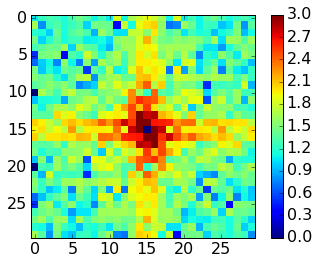

In [115]:
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(img_kjy_per_sr_meansub)))),interpolation='nearest',vmin=0,vmax=3)
plt.colorbar()

In [105]:
from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))


def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def vec2arr(v):
    return np.array(v).flatten()

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optPS(img_meas,pguess,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True,interp_pguess=False,verbose=False):
    n = img_meas.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(img_meas.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini
    #Ccomma_mats = [gen_Ccommabini(bini) for bini in range(nbins)]


    # put in a guess of the data covariance
    if interp_pguess:
        print('a')
        # generate the fourier transform matrix
        lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
        F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2
        Cguess_ft = matrix(np.diag( np.interp(lmaggrid.flatten(),lbincenters,pguess/norm/n**2) ))   
        Csignal = F*Cguess_ft*conj(F).T
    else:
        print('b')
        Csignal = np.matrix(np.zeros((n**2,n**2),dtype=complex))
        for bini in range(nbins):
            Csignal += pguess[bini]/norm/n**2*gen_Ccommabini(bini)
            
    print('c')
    Cmask = 1.e7*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
    print('d')
    Cinv = inv(Csignal + Cmask)

    print('e')
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cinv_mats = []
    print('bins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
        Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
        q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

    # calculate Fisher matrix

    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p0 = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0))
    p1 = vec2arr(inv(Fish)*q*norm)

    return lbincenters,p0,p1,Fish

In [108]:
lmin,lmax = 150,2500
nbins = 6

lbins,pspec_m_h,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
                                  uselogbins=True,usehann=True)
lbins,pspec_m,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
                                  uselogbins=True,usehann=False)

# pguess = np.ones(nbins)
pguess = 1./lbins**2

lbins,p0,p1,Fish_l0_interp = img2optPS(img_kjy_per_sr_meansub,pguess,dtheta_coarse_rad,nbins,lmin,lmax,\
                                                     uselogbins=True,usehann=True,interp_pguess=True,verbose=True)

2180.06087263
2180.06087263

dl = 102
12 cells in \ell=194.9 bin
24 cells in \ell=311.4 bin
64 cells in \ell=497.8 bin
184 cells in \ell=795.5 bin
422 cells in \ell=1271.5 bin
185 cells in \ell=2032.1 bin
a
c
d
e
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5


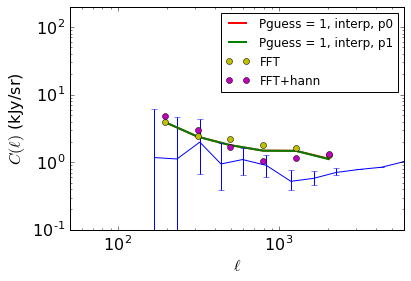

In [110]:
matplotlib.rcParams.update({'font.size': 16})
 
plt.loglog(lbins,sqrt(lbins**2*p0/(2*pi)),'r-',label='Pguess = 1, interp, p0',linewidth=2)
plt.loglog(lbins,sqrt(lbins**2*p1/(2*pi)),'g-',label='Pguess = 1, interp, p1',linewidth=2)

plt.loglog(lbins,sqrt(lbins**2*pspec_m/(2*pi)),'yo',label='FFT')
plt.loglog(lbins,sqrt(lbins**2*pspec_m_h/(2*pi)),'mo',label='FFT+hann')
# plt.loglog(ell_Cell_ciber[:,0],ell_Cell_ciber[:,1],'ko',label='Zemcov+14 CIBER 1.1um data')
plt.errorbar(ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1],yerr=[ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1],\
                                                                 ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1]])
           
plt.legend(fontsize=12)
plt.xlim([50,6000])
plt.ylim([.1,200])
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr)')